# Predicting Financial Stress ( Part 1 )


### Description

Let’s explore a realistic and socially impactful machine learning task — predicting financial stress levels among gig economy workers using data on digital behavior, income streams, and financial activity. Your objective is to analyze the provided dataset, build a classification model, and submit your predictions in a competition-style format.


Financial stress prediction is increasingly important for fintech startups, mental health platforms, and labor unions seeking to identify at-risk individuals. With the growing prevalence of gig work (e.g., ride-sharing, freelance platforms, delivery services), understanding how digital and financial patterns correlate with stress is crucial for designing timely interventions and support systems.


The dataset includes various behavioral, occupational, and financial features collected via consent-based app usage and surveys. Your model should classify each worker into one of three financial stress levels: low, moderate, or high.

The main goal of the task is to achieve the highest possible accuracy score, but unconventional approaches and creative ideas will also be taken into account.

### Evaluation

The target variable is a 3-class categorical variable:

financial_stress_level ∈ {low, moderate, high}

The evaluation metric is **Accuracy**.

### Files

**train.csv**: labeled training data


**test.csv**: unlabeled test data


**sample_submission.csv**: submission format


### Submission Format

Save a CSV file(in current folder) with the following columns:

**worker_id**, **financial_stress_level**

0, Low

1, Moderate

2, High


## Dataset Description

**worker_id** — unique identifier of each gig economy worker

**survey_month** — month when the data was collected

**worker_age** — age of the worker in years

**job_sector** — type of gig job (e.g., delivery, ride-hailing, freelance)

**estimated_annual_income** — self-estimated total income for the year

**monthly_gig_income** — actual monthly earnings from gig work

**num_savings_accounts** — number of savings or checking accounts owned

**num_credit_cards** — total number of active credit cards

**avg_credit_interest** — average interest rate across all credit cards

**num_active_loans** — total number of ongoing personal or payday loans

**avg_loan_delay_days** — average delay in loan repayments, measured in days

**missed_payment_events** — number of missed or late payment events

**recent_credit_checks** — number of credit inquiries in the past 3 months

**current_total_liability** — total amount of outstanding debt

**credit_utilization_rate** — ratio of current credit used to credit limit

**credit_age_months** — duration (in months) since the first credit account was opened

**min_payment_flag** — 1 if only the minimum payment was made, 0 if otherwise

**monthly_investments** — total amount invested or saved in the current month

**spending_behavior** — category describing current spending habits

**end_of_month_balance** — available account balance at month’s end

**financial_stress_level** — [Target] financial stress classification: low / moderate / high

In [112]:
from IPython.display import Markdown, display
from tqdm.notebook import tqdm_notebook as tqdm
import time

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, auc, roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

RANDOM_STATE = 12
np.random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings("ignore")

In [150]:
train_df = pd.read_csv('train.csv').drop('Unnamed: 0', axis=1)

train_df['financial_stress_level'].value_counts()

,count
financial_stress_level,
Moderate,29452
Low,16435
High,10113


In [15]:
train_df.sample(5)

,worker_id,survey_month,worker_age,job_sector,estimated_annual_income,monthly_gig_income,num_savings_accounts,num_credit_cards,avg_credit_interest,num_active_loans,...,missed_payment_events,recent_credit_checks,current_total_liability,credit_utilization_rate,credit_age_months,min_payment_flag,monthly_investments,spending_behavior,end_of_month_balance,financial_stress_level
6500,da32455bea,June,28.0,Writer,72810.29,5865.980000,4,4,17.0,3.0,...,12.0,3.0,1444.26,32.112521,20 y. 7 m.,No,111.885754,"Large expenses, large payments",557.773964,Moderate
27722,410676195a,April,41.0,Doctor,55374.38,NaN,6,3,16.0,2.0,...,19.0,8.0,1570.56,32.641203,12 y. 6 m.,NM,412.456401,"Small expenses, small payments",276.023200,Moderate
11271,a1d10999bb,March,42.0,Media Manager,150342.02,12612.730000,2,5,10.0,NaN,...,12.0,2.0,1443.25,37.295785,19 y. 3 m.,No,225.561149,NaN,1037.622501,Moderate
3448,ec41c14aed,June,26.0,Journalist,145605.13,12212.346667,6,7,20.0,4.0,...,15.0,5.0,501.57,39.418981,19 y. 1 m.,Yes,403.497552,"Large expenses, medium payments",809.226764,Moderate
42985,2a7bc2bb8c,July,NaN,Architect,66813.14,5472.768333,5,2,11.0,1.0,...,8.0,1.0,625.53,32.410653,16 y. 3 m.,No,259.234370,NaN,531.669237,Moderate


In [64]:
object_cols = train_df.select_dtypes(include='object').columns
object_cols = object_cols.drop(['worker_id', 'financial_stress_level'], errors='ignore')

for col in object_cols:
    print(f"{col}")
    display(train_df[col].value_counts())
    print("-" * 30)

survey_month


,count
survey_month,
February,8000
March,8000
April,8000
May,8000
June,8000
July,8000
August,8000


------------------------------
job_sector


,count
job_sector,
Lawyer,3843
Engineer,3646
Architect,3633
Accountant,3623
Media Manager,3546
Teacher,3518
Journalist,3485
Doctor,3484
Developer,3413


------------------------------
credit_age_months


,count
credit_age_months,
17 y. 11 m.,259
19 y. 3 m.,259
15 y. 11 m.,248
19 y. 4 m.,243
19 y. 5 m.,241
...,...
0 y. 3 m.,15
0 y. 2 m.,12
33 y. 6 m.,9


------------------------------
min_payment_flag


,count
min_payment_flag,
Yes,29324
No,19981
NM,6695


------------------------------
spending_behavior


,count
spending_behavior,
"Small expenses, small payments",14283
"Large expenses, medium payments",9835
"Small expenses, medium payments",7795
"Large expenses, large payments",7683
"Large expenses, small payments",6364
"Small expenses, large payments",5809


------------------------------


In [22]:
for col in object_cols:
    missing_count = train_df[col].isnull().sum()
    print(f"{col}: {missing_count}")

survey_month: 0
job_sector: 3983
credit_age_months: 5058
min_payment_flag: 0
spending_behavior: 4231


In [20]:
numerical_cols = train_df.select_dtypes(include=np.number).columns

display(train_df[numerical_cols].describe())

,worker_age,estimated_annual_income,monthly_gig_income,num_savings_accounts,num_credit_cards,avg_credit_interest,num_active_loans,avg_loan_delay_days,missed_payment_events,recent_credit_checks,current_total_liability,credit_utilization_rate,monthly_investments,end_of_month_balance
count,51726.000000,5.207600e+04,47604.000000,56000.000000,56000.000000,54007.000000,50926.000000,56000.000000,49731.000000,53813.000000,55443.000000,56000.000000,51080.000000,55302.000000
mean,33.239125,1.847764e+05,4144.940613,16.906054,22.505857,14.250014,3.518399,20.931179,13.400394,5.627544,1418.509080,32.257797,196.081579,397.835424
std,10.784547,1.495797e+06,3199.911242,116.311458,129.614382,8.486129,2.456607,14.787599,6.240864,3.793041,1158.188602,5.130267,201.156252,213.612536
min,14.000000,6.035990e+03,204.485417,-1.000000,1.000000,0.500000,0.000000,-6.000000,0.000000,0.000000,0.230000,20.000000,0.000000,0.007760
25%,24.000000,1.892614e+04,1572.005108,3.000000,4.000000,7.000000,2.000000,10.000000,9.000000,3.000000,555.880000,28.001990,72.140163,264.939289
50%,33.000000,3.671124e+04,3028.468333,6.000000,6.000000,13.000000,3.000000,18.000000,14.000000,5.000000,1163.470000,32.279565,128.954291,331.802908
75%,42.000000,7.271873e+04,5919.943333,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,8.000000,1922.820000,36.476202,237.305018,464.525826
max,115.000000,2.419779e+07,15202.263333,1798.000000,1499.000000,33.500000,9.000000,69.000000,28.000000,16.000000,4997.100000,50.000000,1961.218850,1592.580519


In [23]:
for col in numerical_cols:
    missing_count = train_df[col].isnull().sum()
    print(f"{col}: {missing_count}")

worker_age: 4274
estimated_annual_income: 3924
monthly_gig_income: 8396
num_savings_accounts: 0
num_credit_cards: 0
avg_credit_interest: 1993
num_active_loans: 5074
avg_loan_delay_days: 0
missed_payment_events: 6269
recent_credit_checks: 2187
current_total_liability: 557
credit_utilization_rate: 0
monthly_investments: 4920
end_of_month_balance: 698


In [24]:
train_df.shape

(56000, 21)

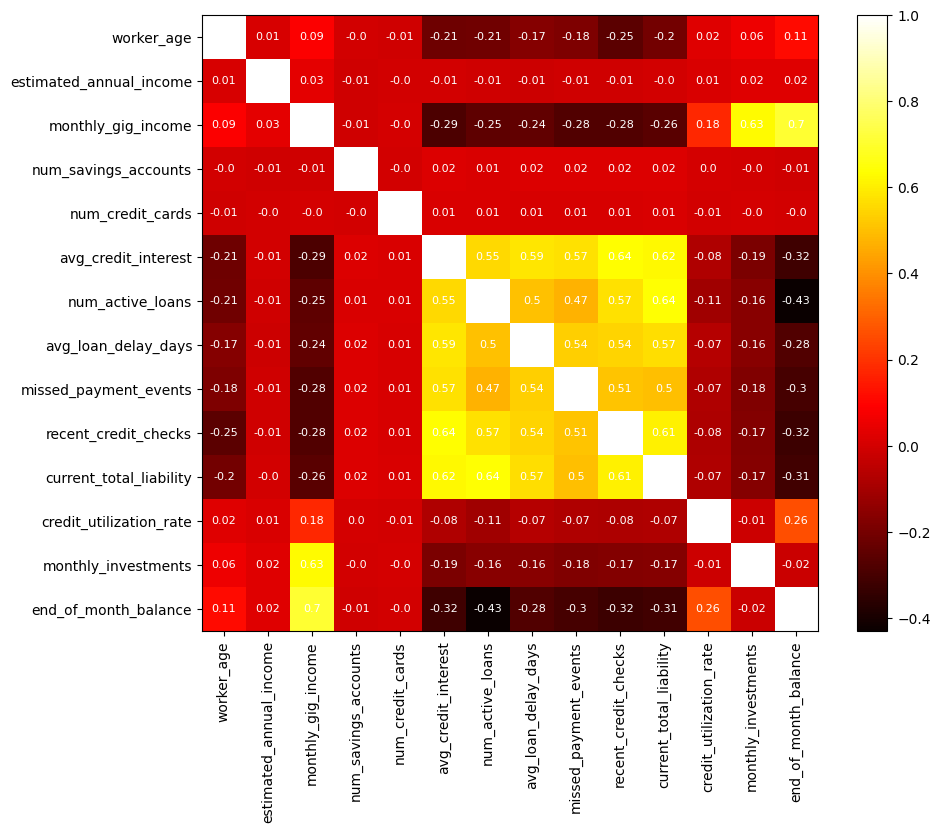

In [29]:
corr_matrix = train_df.select_dtypes(include=np.number).corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='hot', interpolation='nearest')

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = ax.text(j, i, round(corr_matrix.iloc[i, j], 2),
                       ha="center", va="center", color="w", fontsize=8)

plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.colorbar(im)
plt.show()


# !!!!!

Preproc

In [151]:
# credit_age_months to num
train_df['credit_age_months_numeric'] = train_df['credit_age_months'].apply(lambda x: int(x.replace(' y.', '').replace(' m.', '').split(' ')[0]) * 12 + int(x.replace(' y.', '').replace(' m.', '').split(' ')[1]) if pd.notna(x) else np.nan)
train_df.drop('credit_age_months', axis=1, inplace=True)

In [152]:
# fix values < 0
train_df['num_savings_accounts'] = train_df['num_savings_accounts'].apply(lambda x: max(x, 0))
train_df['avg_loan_delay_days'] = train_df['avg_loan_delay_days'].apply(lambda x: max(x, 0))

In [153]:
# numerical
numerical_cols = train_df.select_dtypes(include=np.number).columns
numerical_cols

Index(['worker_age', 'estimated_annual_income', 'monthly_gig_income',
       'num_savings_accounts', 'num_credit_cards', 'avg_credit_interest',
       'num_active_loans', 'avg_loan_delay_days', 'missed_payment_events',
       'recent_credit_checks', 'current_total_liability',
       'credit_utilization_rate', 'monthly_investments',
       'end_of_month_balance', 'credit_age_months_numeric'],
      dtype='object')

In [154]:
# for using later
train_medians = train_df[numerical_cols].median().to_dict()
train_means = train_df[numerical_cols].mean().to_dict()

In [83]:
numerical_cols_outliers = []
outlier_threshold = 1.5

for col in numerical_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - outlier_threshold * IQR
    upper_bound = Q3 + outlier_threshold * IQR

    outliers_count = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col].count()

    if outliers_count > 0:
        numerical_cols_outliers.append(col)

numerical_cols_outliers

['worker_age',
 'estimated_annual_income',
 'monthly_gig_income',
 'num_savings_accounts',
 'num_credit_cards',
 'avg_loan_delay_days',
 'recent_credit_checks',
 'current_total_liability',
 'credit_utilization_rate',
 'monthly_investments',
 'end_of_month_balance']

In [84]:
print(len(numerical_cols))
print(len(numerical_cols_outliers))

15
11


In [85]:
# Fill NaNs by median if there are outliers, otherwise by mean.
for col in numerical_cols:
      if col in numerical_cols_outliers:
          median_val = train_df[col].median()
          train_df[col].fillna(median_val, inplace=True)
      else:
          mean_val = train_df[col].mean()
          train_df[col].fillna(mean_val, inplace=True)

In [86]:
# categorical preproc
object_cols = train_df.select_dtypes(include='object').columns
object_cols = object_cols.drop(['worker_id', 'financial_stress_level'], errors='ignore')

for col in object_cols:
    train_df[col].fillna('Unknown', inplace=True)

In [89]:
train_df.columns

Index(['worker_id', 'survey_month', 'worker_age', 'job_sector',
       'estimated_annual_income', 'monthly_gig_income', 'num_savings_accounts',
       'num_credit_cards', 'avg_credit_interest', 'num_active_loans',
       'avg_loan_delay_days', 'missed_payment_events', 'recent_credit_checks',
       'current_total_liability', 'credit_utilization_rate',
       'min_payment_flag', 'monthly_investments', 'spending_behavior',
       'end_of_month_balance', 'financial_stress_level',
       'credit_age_months_numeric'],
      dtype='object')

Train test split (then train on full data)

In [91]:
RANDOM_STATE = 2025

In [94]:
x = train_df.drop(['financial_stress_level', 'worker_id'], axis=1)
y = train_df['financial_stress_level']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

x_train, x_val, y_train, y_val = train_test_split(x, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded)

numerical_features = x.select_dtypes(include=np.number).columns
categorical_features = x.select_dtypes(include='object').columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

x_train_processed = preprocessor.fit_transform(x_train)
x_val_processed = preprocessor.transform(x_val)

Model

In [106]:
def roc_curve_plot_multiclass(model, X_test, y_test, classes, title='Multiclass AUC-ROC Curve (One-vs-Rest)'):
    y_score = model.predict_proba(X_test)

    y_test_binarized = label_binarize(y_test, classes=classes)
    n_classes = y_test_binarized.shape[1]

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve for class {classes[i]} (AUC = {roc_auc_score(y_test_binarized[:, i], y_score[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    auc_score_overall = roc_auc_score(y_test, y_score, multi_class='ovr', average='weighted')
    print(f'Overall AUC (One-vs-Rest, Weighted Average): {auc_score_overall:.3f}')

In [102]:
def f1_test_rand_forest_depth(X_train, y_train, X_test, y_test, depths=range(1,11), n_estimators=10, class_weight=None):
    '''
    Функция для f1 меры для RandomForestClassifier с глубиной до max_depth,
        кол-м деревьем n_est, выводит график

        Параметры:
        X_train, y_train : train признаки и метки
        X_test, y_test : test признаки и метки
        depths : list
        n_estimators : int - количество деревьев
        class_weight : str - флаг, надо балансировать ли классы

        return:
        tuple : (RandomForestClassifier с наилучшим f1_score, и само значение f1_score)
    '''
    stat = {}
    for dep in depths:
        model = RandomForestClassifier(max_depth=dep, n_estimators=n_estimators,
                                       class_weight=class_weight, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        stat[dep] = f1_score(y_test, y_pred, average='weighted')

    pd.Series(stat).plot(grid=True,
        xlabel = 'Глубина дерева', ylabel = 'F1-мера',
        title  = 'Зависимость f1 меры от глубины деревьев')

    max_f1_depth = max(stat, key=stat.get)
    print("Максимальная F1-мера: n_estimators = {:3d}, max_depth = {:2d} : {:.3f}"
              .format(n_estimators, max_f1_depth, max(stat.values()) ))
    return (RandomForestClassifier(max_depth=max_f1_depth, n_estimators=n_estimators,
                                  class_weight=class_weight, random_state=RANDOM_STATE),
            max(stat.values()) )

def roc_curve_plot(model, X_test, y_test, title='AUC-ROC Curve'):
    '''
    Функция для построения AUC-ROC
    '''
    pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, pred) # false positive rate (fpr), true positive rate (tpr) и thresholds
    roc_auc = auc(fpr, tpr) # Значение площади под ROC-кривой (AUC-ROC)
    plt.figure(figsize=(5,4))
    plt.title(title)
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.grid()
    plt.xlim([0, 1]), plt.ylim([0, 1]) # значения fpr находились в диапазоне от 0 до 1.
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('ROC AUC score:', round(roc_auc, 3))

Progress::   0%|          | 0/5 [00:00<?, ?it/s]

Максимальная F1-мера: n_estimators =  10, max_depth = 30 : 0.731
Максимальная F1-мера: n_estimators =  20, max_depth = 29 : 0.749
Максимальная F1-мера: n_estimators =  30, max_depth = 29 : 0.757
Максимальная F1-мера: n_estimators =  40, max_depth = 29 : 0.764
Максимальная F1-мера: n_estimators =  50, max_depth = 29 : 0.767


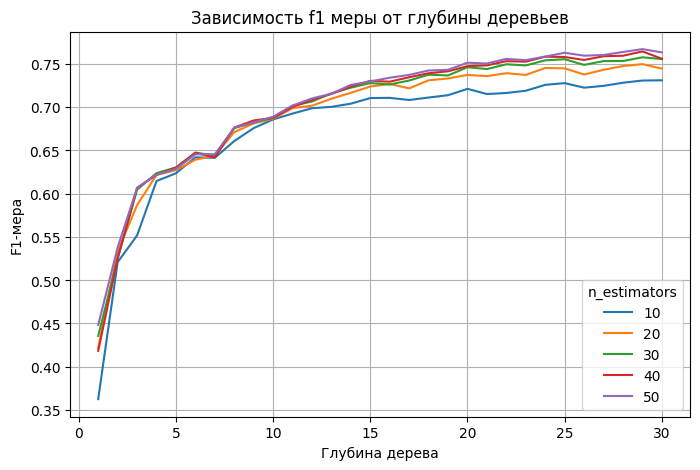

In [103]:
n_est_list = list(range(10, 51, 10))
depths = range(1,31)

prev_score = 0
for n_est in tqdm(n_est_list, desc='Progress:'):
    model, score = f1_test_rand_forest_depth(x_train_processed, y_train, x_val_processed, y_val,
                            depths=depths, n_estimators=n_est)
    if score > prev_score:
        rf_model1 = model

plt.legend(n_est_list, title='n_estimators')

# need more deep model

Progress Experiment 2::   0%|          | 0/13 [00:00<?, ?it/s]

Максимальная F1-мера: n_estimators =  50, max_depth = 33 : 0.769
Максимальная F1-мера: n_estimators =  70, max_depth = 33 : 0.772
Максимальная F1-мера: n_estimators =  90, max_depth = 35 : 0.773
Максимальная F1-мера: n_estimators = 110, max_depth = 33 : 0.774
Максимальная F1-мера: n_estimators = 130, max_depth = 35 : 0.777
Максимальная F1-мера: n_estimators = 150, max_depth = 35 : 0.777
Максимальная F1-мера: n_estimators = 170, max_depth = 33 : 0.775
Максимальная F1-мера: n_estimators = 190, max_depth = 35 : 0.776
Максимальная F1-мера: n_estimators = 210, max_depth = 28 : 0.776
Максимальная F1-мера: n_estimators = 230, max_depth = 35 : 0.777
Максимальная F1-мера: n_estimators = 250, max_depth = 35 : 0.778
Максимальная F1-мера: n_estimators = 270, max_depth = 35 : 0.779
Максимальная F1-мера: n_estimators = 290, max_depth = 35 : 0.778


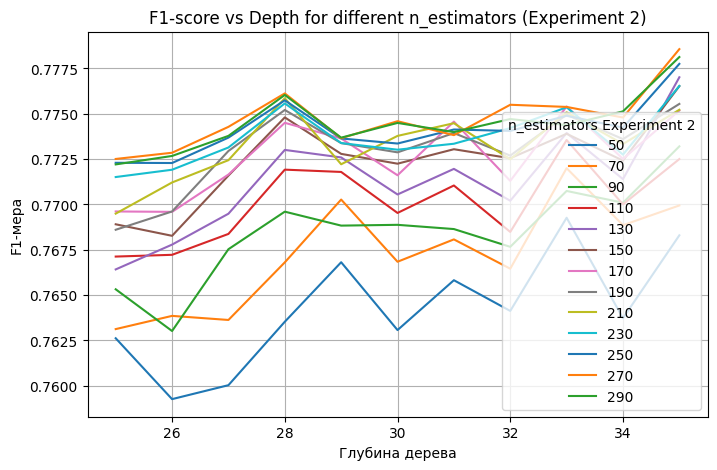

In [104]:
# n_estimators от 50 до 300 с шагом 20 и depths от 25 до 35

n_est_list_2 = list(range(50, 301, 20))
depths_2 = range(25, 36)

prev_score_experiment_2 = 0
for n_est in tqdm(n_est_list_2, desc='Progress Experiment 2:'):
    model, score = f1_test_rand_forest_depth(x_train_processed, y_train, x_val_processed, y_val,
                            depths=depths_2, n_estimators=n_est)
    if score > prev_score_experiment_2:
        rf_model_exp_2 = model
        prev_score_2 = score

plt.legend(n_est_list_2, title='n_estimators Experiment 2')
plt.title('F1-score vs Depth for different n_estimators (Experiment 2)')
plt.show()

# n_estimators = 270
# max_depth = 35

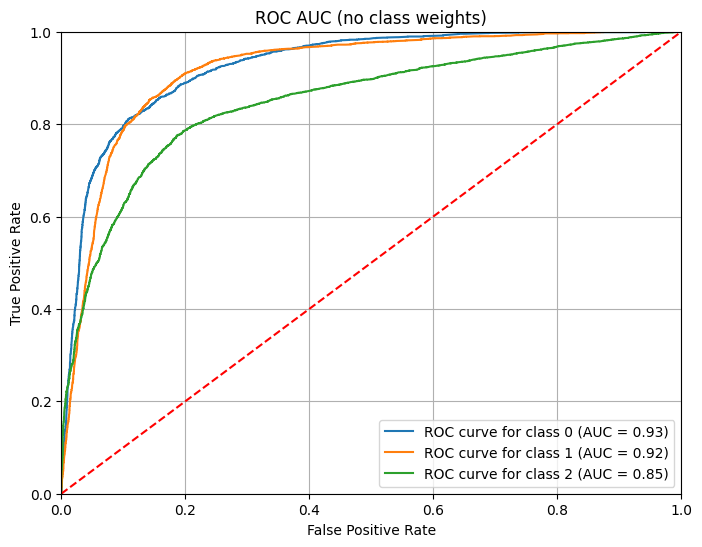

Overall AUC (One-vs-Rest, Weighted Average): 0.883


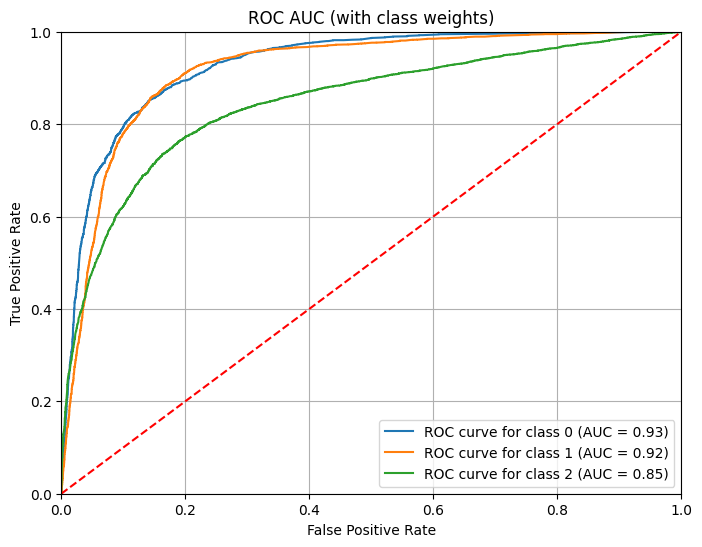

Overall AUC (One-vs-Rest, Weighted Average): 0.882
Accuracy (no weights): 0.779, F1 (no weights): 0.779
Accuracy (with weights): 0.772, F1 (with weights): 0.771


In [115]:
n_trees = 270
depth = 35

classes = np.unique(y_encoded)

rf_plain = RandomForestClassifier(
    n_estimators=n_trees,
    max_depth=depth,
    random_state=RANDOM_STATE
)
rf_plain.fit(x_train_processed, y_train)

pred_plain = rf_plain.predict(x_val_processed)
acc_plain = accuracy_score(y_val, pred_plain)
f1_plain = f1_score(y_val, pred_plain, average='weighted')

roc_curve_plot_multiclass(
    rf_plain, x_val_processed, y_val, classes,
    title='ROC AUC (no class weights)'
)

rf_bal = RandomForestClassifier(
    n_estimators=n_trees,
    max_depth=depth,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
rf_bal.fit(x_train_processed, y_train)

pred_bal = rf_bal.predict(x_val_processed)
acc_bal = accuracy_score(y_val, pred_bal)
f1_bal = f1_score(y_val, pred_bal, average='weighted')

roc_curve_plot_multiclass(
    rf_bal, x_val_processed, y_val, classes,
    title='ROC AUC (with class weights)'
)

print(f"Accuracy (no weights): {acc_plain:.3f}, F1 (no weights): {f1_plain:.3f}")
print(f"Accuracy (with weights): {acc_bal:.3f}, F1 (with weights): {f1_bal:.3f}")

In [ ]:
# best param: n_estimators = 270 max_depth = 35 class_weight=None
# After training, it will be necessary to tune the threshold

In [ ]:
n_trees = 270
depth = 35

Full model

In [121]:
enc = LabelEncoder()
y_enc = enc.fit_transform(y)

prep = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
], remainder='passthrough')

x_prep = prep.fit_transform(x)

clf = RandomForestClassifier(
    n_estimators=n_trees,
    max_depth=depth,
    class_weight=None,
    random_state=RANDOM_STATE
)
clf.fit(x_prep, y_enc)


RandomForestClassifier(max_depth=35, n_estimators=270, random_state=12)

Predict

In [166]:
train_df_for_cols = pd.read_csv('train.csv').drop(['Unnamed: 0', 'financial_stress_level'], axis=1)

test_df = pd.read_csv('test.csv').drop('Unnamed: 0', axis=1)[train_df_for_cols.columns]

In [167]:
test_df[['num_savings_accounts', 'avg_loan_delay_days']] = test_df[['num_savings_accounts', 'avg_loan_delay_days']].clip(lower=0)
test_df['credit_age_months_numeric'] = test_df['credit_age_months'].apply(lambda x: int(x.replace(' y.', '').replace(' m.', '').split(' ')[0]) * 12 + int(x.replace(' y.', '').replace(' m.', '').split(' ')[1]) if pd.notna(x) else np.nan)
test_df.drop('credit_age_months', axis=1, inplace=True)

# fillna by train statistics
for col in numerical_features:
    if col in test_df.columns and test_df[col].isnull().sum() > 0:
        test_df[col].fillna(train_medians[col] if col in numerical_cols_outliers else train_means[col], inplace=True)

for col in categorical_features:
    if col in test_df.columns and test_df[col].isnull().sum() > 0:
        test_df[col].fillna('Unknown', inplace=True)


In [168]:
x_proc = prep.transform(test_df.drop('worker_id', axis=1))
y_pred = enc.inverse_transform(clf.predict(x_proc))
sub_df = pd.DataFrame({'worker_id': test_df['worker_id'], 'financial_stress_level': y_pred})


In [169]:
assert set(train_df['financial_stress_level'].unique()) == set(sub_df['financial_stress_level'].unique()), "Уникальные значения меток не совпадают!"


In [173]:
sub_df.to_csv('submission_Solomennikovа.csv', index=False)

In [172]:
sub_df['financial_stress_level'].value_counts()

,count
financial_stress_level,
Moderate,549
Low,300
High,151


# Probability Theory Problems ( Part 2 )

## Task 1

A standard deck of **52** cards is well shuffled. Find the probability that all **4 aces are positioned next to each other.**

Provide solution below and the answer accurate to 10^-5.

1. **Total number of outcomes** — the number of all possible permutations of cards in the deck:

$$
N = 52!
$$

2. **Favorable outcomes** — cases when all 4 aces are together.  
We treat the group of four aces as a single element, then:

- total elements: \( 52 - 4 + 1 = 49 \)  
- permutations of these 49 elements: \( 49! \)  
- within the block of aces, they can be arranged among themselves: \( 4! \)

$$
N_{\text{favorable}} = 49! \times 4!
$$

Thus, the probability is:

$$
P = \frac{N_{\text{favorable}}}{N} = \frac{49! \times 4!}{52!}
$$


In [111]:
import math

P = (math.factorial(49) * math.factorial(4)) / math.factorial(52)
print('Answer for Task 1:', round(P, 5))


Answer for Task 1: 0.00018


## Task 2

From a collection of letter tiles spelling the word **STATISTICS (10 letters in total)**, 4 tiles are randomly drawn without replacement.

What is the probability that the selected letters can be rearranged to form the word **CAST**?

Provide solution below and the answer accurate to 10^-5.

1. **Total number of outcomes** (without considering order) — the number of ways to choose any 4 letters from 10:

$$
N = \binom{10}{4} = \frac{10!}{4!(10-4)!}
$$

2. **Favorable outcomes** — choosing exactly the letters `C`, `A`, `S`, `T`.  
The count of each letter in the word `STATISTICS`:
- S — 3
- T — **3**
- A — 1
- C — 1
- I — 2

We need to choose 1 letter C from 1, 1 letter A from 1, 1 letter S from 3, and 1 letter T from 3.  
Number of favorable outcomes:

$$
N_{\text{fav}} = \binom{1}{1} \times \binom{1}{1} \times \binom{3}{1} \times \binom{3}{1}
$$

3. **Probability:**

$$
P = \frac{N_{\text{fav}}}{N}
$$`


In [141]:
from math import comb

total = comb(10, 4)
fav = 3 * 3 * 1 * 1
prob = fav / total
print('Answer for Task 2:', round(prob, 3))



Answer for Task 2: 0.043
